# Pytorch CNN for Katakana

## Data loading and preparation

In [5]:
from etldr.etl_data_reader import ETLDataReader
import numpy as np

path_to_data_set = "./ETL_data_set_folder/"


reader = ETLDataReader(path_to_data_set)

from etldr.etl_data_names import ETLDataNames
from etldr.etl_character_groups import ETLCharacterGroups

include = [ETLCharacterGroups.katakana]
#include = [ ETLCharacterGroups.kanji ]
#include = [ ETLCharacterGroups.katakana ]
imgs, labels = reader.read_dataset_part(ETLDataNames.ETL6, include)

print(labels)

Loading all data set files (ETL6_x) from: ./ETL_data_set_folder/ETL6...


  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/13830 [00:00<?, ?it/s]

  0%|          | 0/6915 [00:00<?, ?it/s]

['ア' 'ア' 'ア' ... 'ン' 'ン' 'ン']


### Inspect Data

In [6]:
imgs.shape

(63618, 64, 64, 1)

In [7]:
len(imgs)

63618

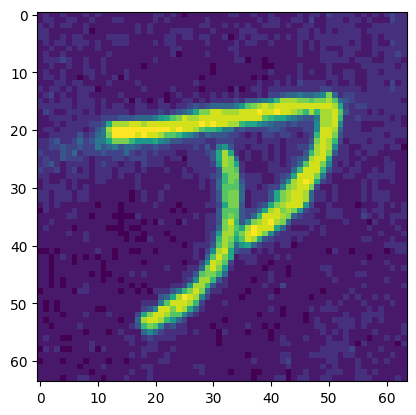

In [8]:
import matplotlib.pyplot as plt
plt.imshow(imgs[0])

### Define label encoding 

In [9]:
import numpy as np

np.unique(labels)
encoding={}
len(np.unique(labels))

46

In [10]:
for i, label in enumerate(np.unique(labels)):
    encoding[label] = i

In [11]:
decoding={}
for key, val in encoding.items():
    decoding[val] = key

In [12]:
import pickle
with open('katakana_labels.pkl', 'wb') as f:
    pickle.dump(decoding, f)

In [13]:
imgsblack =1 - imgs

In [14]:
y = map(lambda x: encoding[x], labels)
y = np.array(list(y))

###  Visualize examples


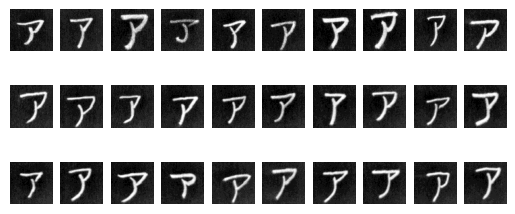

In [15]:

import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 30

for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(imgsblack[index]*255., cmap='gray_r')

### Data splits (train vs val) and pytorch data loading

In [15]:
X = imgs

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [17]:
X= np.transpose(X, (0,3,1,2))

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.1, random_state=42)

In [19]:
X.shape

(63618, 1, 64, 64)

In [20]:
train_data = TensorDataset( torch.tensor(X_train,dtype=torch.float), torch.tensor(y_train,dtype=torch.int64) ) 

In [21]:
test_data = TensorDataset(torch.tensor(X_test,dtype=torch.float), torch.tensor(y_test,dtype=torch.int64))

In [22]:
X_test.shape

(6362, 1, 64, 64)

In [23]:
len(test_data)

6362

In [24]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True,pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, pin_memory=True)

### View batched Data

(3, 266, 530)


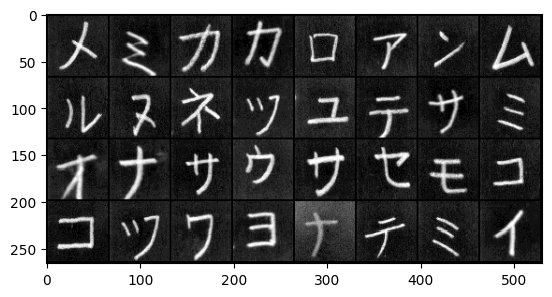

33315542045324022231736181031420102101334991743372018311


In [25]:
import torchvision

import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img    # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    #plt.imshow(npimg)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(''.join('%1s' % labels[j].numpy() for j in range(32)))

In [26]:
images.shape

torch.Size([32, 1, 64, 64])

## Define Model

Define CNN model

In [27]:
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

In [31]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.conv4_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 13 * 13, 128)
        self.fc2 = nn.Linear(128, 46)
        self.dropOut = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.dropOut(x)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = self.dropOut(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.dropOut(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = self.dropOut(x)
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = self.dropOut(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
device = 'cuda'

model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=46, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

## Perform training

In [35]:
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
epoch_log = []
loss_log = []
val_loss_log = []
accuracy_log = []
val_accuracy_log = []

In [ ]:
epochs = 10
    

for epoch in range(epochs):  
    print(f'Epoch: {epoch+1}')

    running_loss = 0.0
    running_correct = 0.0 
    running_total = 0.0
    actual_loss = 0.0
    # loop over training batches
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)

        # compute loss
        loss =  criterion(outputs, labels)

        # backward propagation
        loss.backward()
        optimizer.step()

        # add batch loss to running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim = 1)

        running_total += labels.size(0)

        running_correct += (predicted == labels).sum().item()

        if i % 100 == 99:    
            valcorrect = 0 
            valtotal = 0 
            running_val_loss = 0

            with torch.no_grad():
                for data in val_loader:

                    # apply model to validation batch
                    images, labels = data

                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)

                    val_loss =  criterion(outputs, labels)

                    _, predicted = torch.max(outputs.data, dim = 1)

                    valtotal += labels.size(0)

                    valcorrect += (predicted == labels).sum().item()
                    
                    running_val_loss += val_loss.item() 

                val_accuracy = 100 * valcorrect / valtotal
                accuracy = 100 * running_correct / running_total
                epoch_num = epoch + 1
                
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Train Accuracy = {accuracy:.3f}%')
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Val Accuracy = {val_accuracy:.3f}%')
                

    actual_loss = running_loss / running_total
    actual_val_loss = running_val_loss / valtotal
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    val_loss_log.append(actual_val_loss)
    accuracy_log.append(accuracy)
    val_accuracy_log.append(val_accuracy)
    print('\n')
    print(f"Epoch {epoch_num} summary stats:")
    print(f'Train Loss: {actual_loss:.4f}, Train Accuracy = {accuracy:.3f}%')
    print(f'Val Loss: {actual_val_loss:.4f}, Val Accuracy = {val_accuracy:.3f}%')
    print('\n')
    print('\n')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 0.027, Test Accuracy = 98.727%
Epoch: 1, Mini-Batches Completed: 100, Loss: 0.025, Test Accuracy = 98.994%
Epoch: 1, Mini-Batches Completed: 150, Loss: 0.010, Test Accuracy = 99.073%
Epoch: 1, Mini-Batches Completed: 200, Loss: 0.013, Test Accuracy = 98.994%
Epoch: 1, Mini-Batches Completed: 250, Loss: 0.011, Test Accuracy = 99.104%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.017, Test Accuracy = 99.088%
Epoch: 1, Mini-Batches Completed: 350, Loss: 0.017, Test Accuracy = 98.963%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.013, Test Accuracy = 98.963%
Epoch: 1, Mini-Batches Completed: 450, Loss: 0.017, Test Accuracy = 99.104%
Epoch: 1, Mini-Batches Completed: 500, Loss: 0.009, Test Accuracy = 99.010%
Epoch: 1, Mini-Batches Completed: 550, Loss: 0.027, Test Accuracy = 98.994%
Epoch: 1, Mini-Batches Completed: 600, Loss: 0.017, Test Accuracy = 99.120%
Epoch: 1, Mini-Batches Completed: 650, Loss: 0.009, Test Accuracy = 

In [34]:
PATH = './katakana_pytorch_2.pth'
torch.save(model.state_dict(), PATH)

In [97]:
y

array([ 0,  0,  0, ..., 45, 45, 45])